***Parameter Definitions***

In [3]:
nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
m                       = 16                            # Number of Patterns
dd_factor               = 2                             # Detector Downsampling Factor

Load object

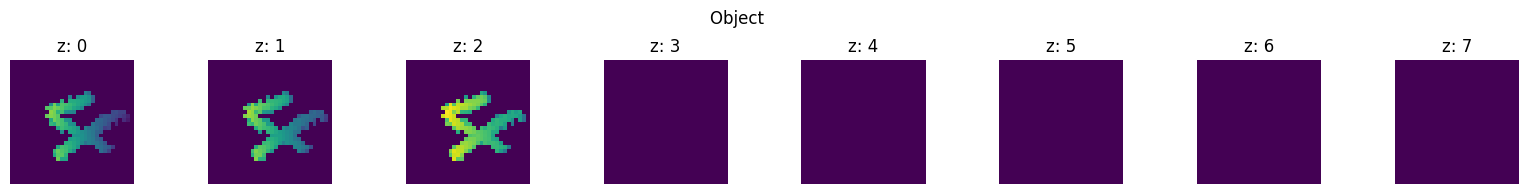

In [8]:
from libs.forward_lib.read_data import ReadData
from libs.forward_lib.simulate_data import MnistSimulator
import numpy as np

# RD = ReadData(nx, ny, nz)
# RD.load_object("blood_cell")
# RD.visualize_data(is_orginal=True)
# X = RD.X.cpu().numpy().reshape(nx*ny*nz, 1)

MS = MnistSimulator(nx, ny, nz, up_factor=(1/8,1,1))
MS.update_data()
X = MS.X.cpu().numpy().reshape(nx*ny*nz, 1)
MS.visualize_object(vis_planes=True)

Linearized Model

In [4]:
from libs.forward_lib.linearized_process_D2NN import LinearizedModel

LM = LinearizedModel(nx, ny, nz, m, dd_factor, n_planes=1)
LM.dx, LM.dy, LM.dz = 1.0, 1.0, 1.0
LM.init_models()
LM.PM.dx, LM.PM.dy, LM.PM.dz = 1.0, 1.0, 1.0
LM.find_transformation()
print(LM)

FM = LM.A.cpu().numpy()

Pattern: 16/16	 Nz: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
D2NN Patterns 			: 16
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cpu




In [9]:
y_clean = FM@X

def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(m*(nx//dd_factor)*(ny//dd_factor), 1)

Run twist


Initial objective = 3471204.5104461582, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Incrementing S = 2048
Incrementing S = 4096
Incrementing S = 8192
Incrementing S = 16384
Incrementing S = 32768
Incrementing S = 65536
Incrementing S = 131072
Incrementing S = 262144
Incrementing S = 524288
Iteration = 2, objective = 248907.69143667974, nz = 7168, criterion = 92.82935676398141
Iteration = 3, objective = 186704.25355943595, nz = 7168, criterion = 24.99056478255429
Iteration = 4, objective = 75209.64749132632, nz = 7168, criterion = 59.71722868789174
Iteration = 5, objective = 65916.69385821017, nz = 7168, criterion = 12.35606593447719
Iteration = 6, objective = 61876.41276760539, nz = 7168, criterion = 6.129374600151536
Iteration = 7, objective = 55762.5445108353, nz = 7168, criterion = 9.880773599032759
Iteration = 8,

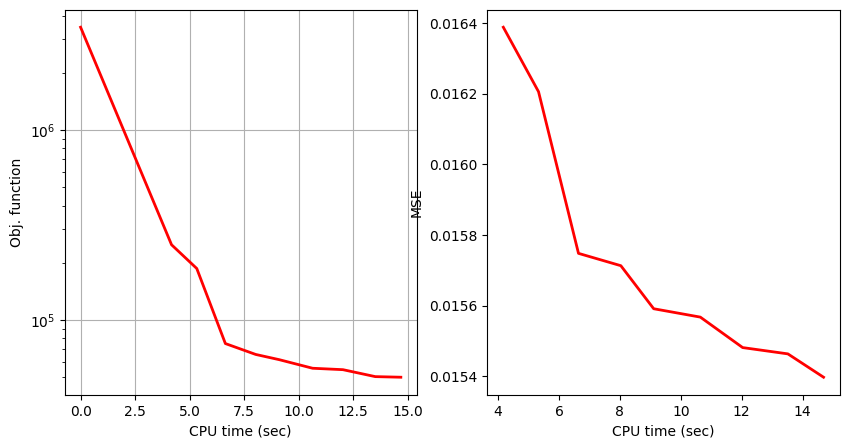

TwIST CPU time: 14.6875
MSE Loss: 1.5398e-02


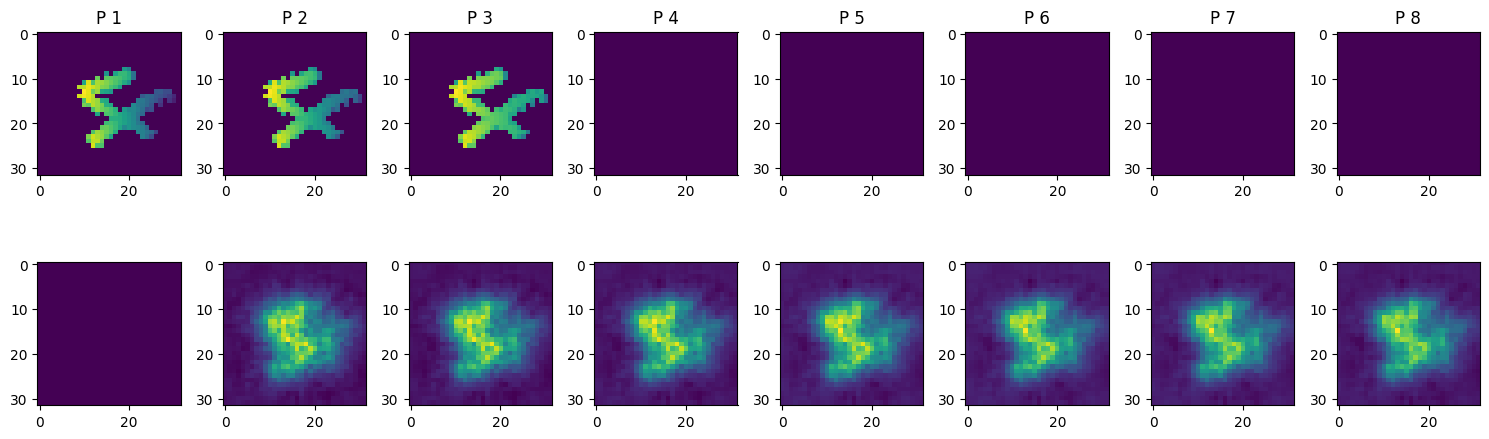

plane 1 | SSIM = nan | PSNR = -inf dB
plane 2 | SSIM = 0.1530 | PSNR = 1.3271 dB
plane 3 | SSIM = 0.1334 | PSNR = -1.3725 dB
plane 4 | SSIM = 0.0795 | PSNR = 11.2701 dB
plane 5 | SSIM = 0.0824 | PSNR = 11.4815 dB
plane 6 | SSIM = 0.0857 | PSNR = 11.7880 dB
plane 7 | SSIM = 0.0873 | PSNR = 11.9106 dB
plane 8 | SSIM = 0.0853 | PSNR = 11.8728 dB


In [12]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

tau = 0 # Regularization parameter
Psi = 'SOFT_DWT' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'L1_DWT' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-2 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))